
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Projet A2021 : Prédire les maladies cardiaques

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/3a185493d8bb48d8961ad50e465bed4f

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre numéro d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul fichier .ipynb par équipe faisant office de rapport et permettant de reproduire vos meilleures prédictions doit être remis.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : on prédit 0 débordement à tous les jours. Ce sera votre travail d'améliorer ces prédictions naïves avec la méthode de votre choix.

Il faudra que vous trouviez un moyen de traiter les données manquantes. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est appropriée.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode déjà implémentée et infructueuse.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.

In [31]:
using CSV, DataFrames, Gadfly, GLM, Statistics, MLBase
include("Math.jl")


age_to_string (generic function with 1 method)

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [2]:
data = CSV.read("train.csv", DataFrame)
first(data,5)

5×13 DataFrame
 Row │ ID     Age    Sex     ChestPainType  RestingBP  Cholesterol  FastingBS  ⋯
     │ Int64  Int64  String  String         Int64      Int64?       Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     69  M       ASY                  140          110          1  ⋯
   2 │     2     60  M       ASY                  140          293          0
   3 │     3     52  M       ASY                  165      missing          1
   4 │     4     46  M       NAP                  120          230          0
   5 │     5     61  M       NAP                  120      missing          0  ⋯
                                                               6 columns omitted

In [3]:
"""
    rocplot(gt::Array{<:Real},scores::Array{<:Real})
Show the ROC curve corresponding to the ground truth `gt` and the success probability `scores`.
The curve is computed for 100 equally spaced thresholds.
"""
function rocplot(gt::Array{<:Real},scores::Array{<:Real})

    # Compute the ROC curve for 100 equally spaced thresholds - see `roc()`
    r = roc(gt, scores, 0:.01:1)

    # Compute the true positive rate and false positive rate
    tpr = true_positive_rate.(r)
    fpr = false_positive_rate.(r)

    return plot(x=fpr, y=tpr, Geom.line, Geom.abline(color="red", style=:dash),
        Guide.xlabel("False Positive Rate"), Guide.ylabel("True Positive Rate"))

end

rocplot

#### 1.1 Informations sur les données

**Age** : âge du patient (années) </br>

**Sex** : le sexe du patient (M pour homme et F pour femme) </br>

**ChestPainType** : TA: Angine de poitrine typique, ATA: Angine de poitrine atypique, NAP: Douleur autre que l'angine, ASY: Asymptomatique]

Définitions:

Asymptomatique: Aucune douleur

ANGINE: L’angine survient dans des situations où le cœur doit fournir un effort supplémentaire, mais ne parvient pas à recevoir suffisamment d’oxygène en raison du rétrécissement d’une artère coronaire par l’artériosclérose.

TA: Angine typique qui survient lors des efforts connus et reproductibles

ATA: Lorsque l'angine de poitrine atypique alors elle peut de durée prolongée et peut survenir au repos. Habituellement, **une angine instable ou atypique peut être annonciatrice d'un infractus du myocarde (crise cardiaque).**

NAP: Douleur autre que l'angine

Source: https://www.icm-mhi.org/fr/soins-et-services/maladies-cardiovasculaires/angine-de-poitrine

ASY: aucune douleur de chest

**RestingBP** : tension artérielle au repos (en mm Hg)

On a ici les tensions systoliques qui est la force exerc/e lorsque le coeur se contracte et expluse le sang.

Risque faible: 120

Risque moyen: 121-134

Risque élevé: 135+

Source: https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/hypertension-arterielle

**Cholesterol** : taux de cholesterol (en mm/dl)


Le cholestérol est un lipide qui est produit naturellement par le corps, mais dont la quantité peut augmenter en fonction de notre régime alimentaire.


Source: https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/taux-eleve-de-cholesterol

**FastingBS** : glycémie à jeun (1 si FastingBS > 120 mg/dl, 0 sinon)

Hyperglycémie modérée ou diabète.

Source: https://sante.journaldesfemmes.fr/fiches-anatomie-et-examens/2423998-glycemie-a-jeun-taux-normal-definition-elevee-basse-comment-baisser/

**RestingECG** : électrocardiogramme au repos (Normal : normal ; ST : anomalie ST-T détectée ; LVH : hypertrophie du ventricule gauche)


LVH: 

Hypertrophie: Accroissement de la taille du coeur avec les parois du coeur qui s'épaississent. Peut se produire lorsque le coeur subit une charge de travail élevée pendant de longues périodes de temps.
    
Ventricule gauche: épaissement du muscle de la cavité inférieure gauche du coeur

Source: https://www.coeuretavc.ca/maladies-du-coeur/problemes-de-sante/hypertrophie-du-coeur

**MaxHR** : rythme cardiaque maximum (battements par minutes)

**ExerciseAngina** : angine causée par l'exercice (Y: oui ; N: non)

**Oldpeak** : mesure sur l'électrocardiogramme (https://en.wikipedia.org/wiki/ST_depression)

**ST_Slope** : la pente sur l'électrocardiogramme (Up: croissante ; Flat : constante ; Down : décroissante)

Up: Peut etre mauvais

Flat: Bon

Down: Peut etre mauvais

## 2. Analyse exploratoire sommaire

#### 2.1 Diagrammes à moustache en fonction du diagnostic et du sexe

Nous allons faire les boxplots pour toutes les variables quantitatives. Ensuite, nous allons les séparer en catégorie homme/femme pour voir s'il y a une distribution différente, car nos recherches préalables nous montraient que les hommes et les femmes pouvaient avoir une pression normale différente par exemple.

**Observations clées**:

**RestingBP**:
 - Le restingBP ne variait pas énormément sur nos données. On peut le voir en remarquant que la médiane est presque la même pour quand on ne différencie pas hommes et femmes peu importe leur diagnostic. En différenciant selon le sexe, on remarque que la courbe des hommes ne changent presque pas en fonction de s'ils sont malades ou pas. Cependant, pour les femmes, le restingBP des femmes malades est beaucoup plus élevé que ceux qui sont en santé.

**Cholesterol**:
 - Le taux de cholesterol uniquement semble être légérement supérieur lorsque les gens sont atteints de maladies cardiaques. Quand on sépare en catégories hommes, femmes on observe que le taux de cholestérol chez les femmes semble sensiblement plus élevé quand elles sont malades que lorsqu'elles ne le sont pas. Pour les hommes on remarque une légère différence.

**MaxHR**:
  - Le max HR semble être une très bonne variable explicatrice. En effet, plus il est élevé, moins les gens semblent être atteints de maladies cardiaques. On observe autant ce phénomène chez les hommes que chez les femmes.

**OldPeak**
  - Le old Peak semble également être une excellente variable explicatrice, car il semble être beaucoup plus bas lorsque les gens sont en bonnes santé et ce autant pour les hommes que pour les femmes.
  
**Age**
  - L'age semble important, car plus les personnnes sont agées plus elles semblent être sensibles aux maladies cardiaques. On observe ce phénomène chez les hommes et les femmes.

#### 2.1.1 RestingBP

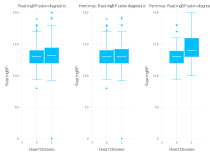

In [4]:
set_default_plot_size(21cm, 16cm)

f1 = plot(data, x=:HeartDisease, y=:RestingBP, Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75), Guide.title("RestingBP selon diagnostic"))
hommes, femmes = groupby(data, :Sex)
f2 = plot(hommes, x=:HeartDisease, y=:RestingBP, Guide.title("Hommes: RestingBP selon diagnostic"), Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:RestingBP, Guide.title("Femmes: RestingBP selon diagnostic"), Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

#### 2.1.3 Cholestérol

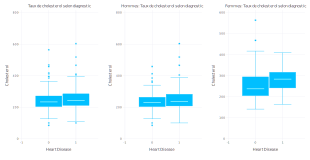

In [5]:
set_default_plot_size(31cm, 16cm)
data_no_missing = dropmissing(data)
f1 = plot(data_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
hommes_no_missing = dropmissing(hommes)
femmes_no_missing = dropmissing(femmes)
f2 = plot(hommes_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Hommes: Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Femmes: Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

#### 2.1.4 MaxHR

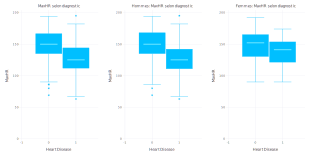

In [6]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("Hommes: MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("Femmes: MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

#### 2.1.5 Age

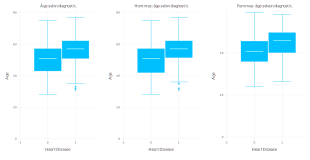

In [7]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Âge selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Hommes: âge selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Femmes: âge seleon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75, ymin=-1))
gridstack([f1 f2 f3])


#### 2.1.6 Oldpeak

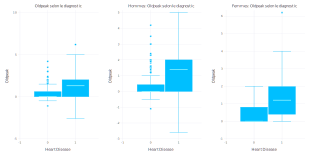

In [8]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Hommes: Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Femmes: Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75, ymin=-1))
gridstack([f1 f2 f3])

#### 2.2 Diagrammes en violon des caractéristiques en fonction du diagnostic

Dans cette section, des **violin plot** sont présentés pour chacune des caractéristique et sont divisés selon le diagnostic du patient. Ces diagrammes permettent de visualiser la densité de probabilité approximative de la caractéristique. Pour cette section d'exploration, seulement les caractéristiques avec des données numériques ont été choisies.
 
##### Observations clés

**Age**:

- Les personnes en bas de 50 ans semblent avoir une plus petite probabilité d'avoir une maladie cardiaque
- Le mode des personnes diagnostiquées avec une maladie cardiaque semblent être autour de 55 ans
- Pouvoir prédictif semble moyen

**RestingBP**:

- Aucune diffirénce substantielle entre les personnes malades ou non selon cette caractéristique
- Pouvoir prédictif semble faible
    
**Cholesterol**:

- Distribution du choléstérol pour les personnes qui ne sont pas malades semblent être une normale centrée en 200
- Distribution du choléstérol pour les personnes qui malades a deux sommets visibles en 200 et 250
- Il semble être plus probable d'avoir un cholestérol élevé (250 et plus) si la personne est malade
- Pouvoir prédictif semble moyen
    
**MaxHR**:

- Les distributions semlbent être des inverses
- Les modes pour les personnes malades et non malades sont très différents: 125 vs 160
- Semble être probable qu'une personne ait un bas rythme cardiaque maximum si elle est malade
- Pouvoir prédictif semble fort

**Oldpeak**:

- On voit que la variance de la mesure sur l'électrocardiogramme est très faible pour les personnes non malades
- Les valeurs sont centrées autours de 0 (une pente nulle du segment ST) pour les personnes non malades
- Les malades, ont des valeurs souvent supérieures à 0 et le mode est autour de 1.25
- Possiblité de discrimer les gens non à risque avec une mesure nulle, bien qu'il y ait des execeptions
- Pouvoir prédictif semble fort


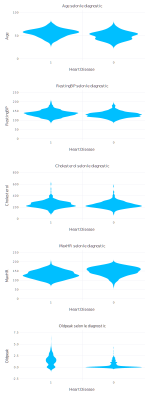

In [9]:
plots = Plot[]

# Enelver les lignes avec des données missing
full_rows_data = dropmissing(data)

# Faire le diagramme seulement pour les caractéristiques numériques
for caracteristic_name in propertynames(full_rows_data[!, [:Age, :RestingBP, :Cholesterol, :MaxHR, :Oldpeak]])
    push!(
        plots,
        plot(
            full_rows_data, 
            x=:HeartDisease,
            y=caracteristic_name,
            Geom.violin,
            Guide.title("$caracteristic_name selon le diagnostic")
        )
    )
end

Gadfly.set_default_plot_size(15cm, 40cm)
Gadfly.vstack(plots...)

Dans cette section, des **violin plot** sont présentés pour chacune des caractéristique et sont divisés selon le diagnostic du patient. Ces diagrammes permettent de visualiser la densité de probabilité approximative de la caractéristique. Pour cette section d'exploration, seulement les caractéristiques avec des données numériques ont été choisies.
 
#### Observations clés

**Age**:

- Les personnes en bas de 50 ans semblent avoir une plus petite probabilité d'avoir une maladie cardiaque
- Le mode des personnes diagnostiquées avec une maladie cardiaque semblent être autour de 55 ans
- Pouvoir prédictif semble moyen

**RestingBP**:

- Aucune diffirénce substantielle entre les personnes malades ou non selon cette caractéristique
- Pouvoir prédictif semble faible
    
**Cholesterol**:

- Distribution du choléstérol pour les personnes qui ne sont pas malades semblent être une normale centrée en 200
- Distribution du choléstérol pour les personnes qui malades a deux sommets visibles en 200 et 250
- Il semble être plus probable d'avoir un cholestérol élevé (250 et plus) si la personne est malade
- Pouvoir prédictif semble moyen
    
**MaxHR**:

- Les distributions semlbent être des inverses
- Les modes pour les personnes malades et non malades sont très différents: 125 vs 160
- Semble être probable qu'une personne ait un bas rythme cardiaque maximum si elle est malade
- Pouvoir prédictif semble fort

**Oldpeak**:

- On voit que la variance de la mesure sur l'électrocardiogramme est très faible pour les personnes non malades
- Les valeurs sont centrées autours de 0 (une pente nulle du segment ST) pour les personnes non malades
- Les malades, ont des valeurs souvent supérieures à 0 et le mode est autour de 1.25
- Possiblité de discrimer les gens non à risque avec une mesure nulle, bien qu'il y ait des execeptions
- Pouvoir prédictif semble fort


#### 2.3 Histogrammes des caractéristiques en fonction du diagnostic

Pour savoir si certains paramètres suivent des distributions différentes en fonction de la variable d'intérêt (HeartDisease), nous avons généré des histogrammes pour chaque variable dans le cas des patients malades et des patients sains. Cela peut être utile pour déterminer si un mélange de loi peut être utilisé pour certaines variables ou pas.

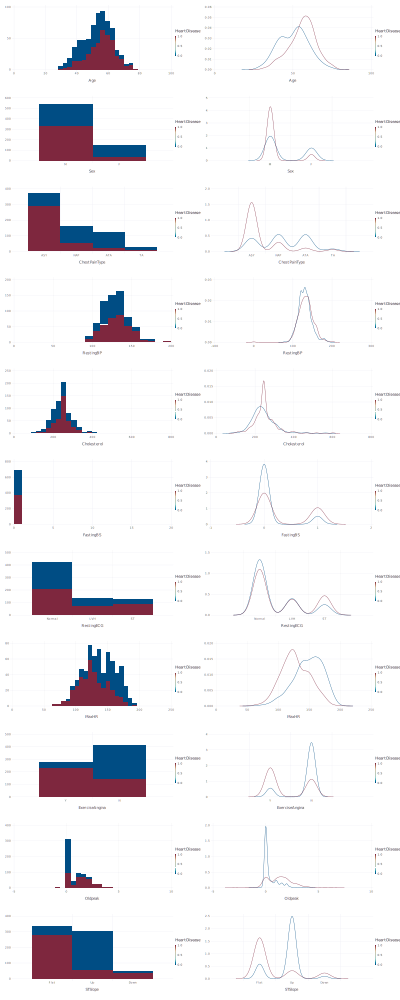

In [10]:
mean_cholesterol = mean(skipmissing(data.Cholesterol));
filled_data = coalesce.(data, mean_cholesterol);

graphs = Plot[]

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.histogram(bincount=20)))
end

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.density()))
end

Gadfly.set_default_plot_size(40cm, 100cm)
Gadfly.gridstack(reshape(graphs, 11, 2))

#### 2.4 Analyse de la corrélation des variables

#### Observations clés

Il ne semble pas avoir de multicolinéarité entre les différentes variables explicatives quantitatives puisqu'on remarque des carrés rouges (1) seulement selon la diagonale dans laquelle la variable est corrélée à elle même. Pour les autres paires de variables explicatives, on voit que la corrélation est proche de 0.

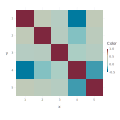

In [11]:
full_rows_data = dropmissing(data)
Gadfly.set_default_plot_size(12cm, 12cm)
spy(cor(Matrix(full_rows_data[!, [:Age, :RestingBP, :Cholesterol, :MaxHR, :Oldpeak]])))

## 3. Données manquantes, ensemble de test et de validation

Dans cette section, on remplace les données manquantes des variables aléatoires afin de pouvoir utiliser l'observation pour l'entraînement des modèles.

In [12]:
# Changer les missing avec la moyenne du cholestérol
mean_cholesterol = mean(skipmissing(data.Cholesterol));
filled_data = coalesce.(data, mean_cholesterol);

# Convertir les variables catégorielles en String
filled_data.FastingBS = string.(filled_data.FastingBS)


# Échantilloner les lignes pour l'ensemble d'entraînemenet et de validation
train_id = sample(1:nrow(filled_data), round(Int, .8*nrow(filled_data)), ordered=true)
valid_id = setdiff(1:nrow(filled_data), train_id)

# Initialiser l'ensemble d'entraînement et de validation
train = filled_data[train_id,:]
valid = filled_data[valid_id,:]

313×13 DataFrame
 Row │ ID     Age    Sex     ChestPainType  RestingBP  Cholesterol  FastingBS  ⋯
     │ Int64  Int64  String  String         Int64      Float64      String     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     69  M       ASY                  140      110.0    1          ⋯
   2 │     2     60  M       ASY                  140      293.0    0
   3 │     3     52  M       ASY                  165      244.986  1
   4 │     6     46  M       NAP                  150      231.0    0
   5 │     9     43  M       ASY                  150      247.0    0          ⋯
   6 │    11     43  M       NAP                  130      315.0    0
   7 │    12     36  M       NAP                  150      160.0    0
   8 │    14     37  M       NAP                  118      240.0    0
   9 │    18     57  M       ASY                   95      244.986  1          ⋯
  10 │    19     56  M       ASY                  150      213.0    1
  11 │    20     68  M       NAP                  118      277.0    0
  ⋮  │   ⋮      ⋮      ⋮           ⋮            ⋮           ⋮           ⋮      ⋱
 304 │   669     64  M       ASY                  145      212.0    0
 305 │   671     51  M       ATA                  130      224.0    0          ⋯
 306 │   672     74  M       NAP                  140      237.0    1
 307 │   676     51  M       ASY                  132      227.0    1
 308 │   679     60  M       NAP                  140      185.0    0
 309 │   680     38  M       ASY                  110      190.0    0          ⋯
 310 │   682     54  F       ATA                  150      230.0    0
 311 │   683     44  M       ATA                  120      220.0    0
 312 │   685     66  F       ASY                  155      244.986  1
 313 │   687     34  F       ATA                  130      161.0    0          ⋯
                                                  6 columns and 292 rows omitted

## 4. Ajustement des modèles

### 4.1 Modèle de base M1

#### 4.1.1 Construire le modèle

Le premier modèle est celui de base. C'est une simple régression logistique qui utilise toutes les variables explicatives fournies avec une fonction de lien Logit

**M1**:  HeartDisease ~ Age + Sex + ChestPainType + RestingBP + Cholesterol + FastingBS + RestingECG + MaxHR + ExerciseAngina +          Oldpeak + STSlope 

In [13]:
# Construire le modèle de régression logistique
M1 = glm(@formula(
        HeartDisease ~ Age + Sex + ChestPainType + RestingBP + Cholesterol + 
        FastingBS + RestingECG + MaxHR + ExerciseAngina + Oldpeak + STSlope), 
        train, Bernoulli(), LogitLink()
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

HeartDisease ~ 1 + Age + Sex + ChestPainType + RestingBP + Cholesterol + FastingBS + RestingECG + MaxHR + ExerciseAngina + Oldpeak + STSlope

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error      z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -6.79971     1.84068     -3.69    0.0002  -10.4074      -3.19205
Age                  0.0367883   0.0175651    2.09    0.0362    0.00236134   0.0712153
Sex: M               2.07449     0.372494     5.57    <1e-07    1.34441      2.80456
ChestPainType: ATA  -1.88543     0.417577    -4.52    <1e-05   -2.70387     -1.06699
ChestPainType: NAP  -1.2

#### 4.1.2 Mesurer la qualité du modèle **M1**

Évaluer la qualité du modèle sur l'ensemble **d'entraînement**

In [14]:
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ̂ = predict(M1, train)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ = Int64[]
for θ̂ᵢ in θ̂
    if θ̂ᵢ >= .5
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end

Calculer la précision de notre modèle sur l'ensemble de test

In [15]:
println("Le taux de bonnes prédictions sur l'ensemble d'entraînement est de ", round(correctrate(train.HeartDisease, ŷ), digits=3),".")

Le taux de bonnes prédictions sur l'ensemble d'entraînement est de 0.858.


Évaluer la qualité du modèle sur l'ensemble de **validation**

In [16]:
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred = predict(M1, valid)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ = Int64[]
for θ̂ᵢ in θ_pred
    if θ̂ᵢ >= .5
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end

Calculer la précision de notre modèle sur l'ensemble de validation

In [17]:
println("Le taux de bonnes prédictions sur l'ensemble de validation est de ", round(correctrate(valid.HeartDisease, ŷ), digits=3),".")

Le taux de bonnes prédictions sur l'ensemble de validation est de 0.85.


Afficher la courbe ROC pour le modèle M1

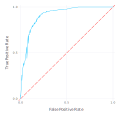

In [18]:
θ_pred = convert(Array{Float64}, θ_pred)
rocplot(valid.HeartDisease, θ_pred)

Trouver le meilleur threshold pour le modèle

In [19]:
λ_M1 = find_best_threshold(valid, M1)

# Tester le taux de bonnes prédiction avec λ = best_threshold
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred = predict(M1, valid)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ = Int64[]
for θ̂ᵢ in θ_pred
    if θ̂ᵢ >= λ_M1
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end
println("Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=$λ_M1 est de ", round(correctrate(valid.HeartDisease, ŷ), digits=3),".")

### 4.2 Modèle M2

#### 4.2.1 Construire le modèle

Pour le deuxième modèle, on a décidé de faire deux sous-modèles (1 par sexe) en utilisation la régression logistique avec toutes les variables explicatives sauf le sexe. On utilise encore une fois une fonction de lien Logit.

**M2_hommes** / **M2_femmes**:  HeartDisease ~ Age + ChestPainType + RestingBP + Cholesterol + FastingBS + RestingECG + MaxHR                                    ExerciseAngina + Oldpeak + STSlope 

In [21]:
# Construire deux ensemble de test séparé par le sexe
train_hommes = filter(row -> row.Sex == "M", train)
train_femmes = filter(row -> row.Sex == "F", train)

# Construire deux ensemble de validation séparé par le sexe
valid_hommes = filter(row -> row.Sex == "M", valid)
valid_femmes = filter(row -> row.Sex == "F", valid)


M2_hommes = glm(@formula(
        HeartDisease ~ Age + ChestPainType + RestingBP + Cholesterol + 
        FastingBS + RestingECG + MaxHR + ExerciseAngina + Oldpeak + STSlope), 
        train_hommes, Bernoulli(), LogitLink()
)

M2_femmes = glm(@formula(
        HeartDisease ~ Age + ChestPainType + RestingBP + Cholesterol + 
        FastingBS + RestingECG + MaxHR + ExerciseAngina + Oldpeak + STSlope), 
        train_femmes, Bernoulli(), LogitLink()
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

HeartDisease ~ 1 + Age + ChestPainType + RestingBP + Cholesterol + FastingBS + RestingECG + MaxHR + ExerciseAngina + Oldpeak + STSlope

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                            Coef.    Std. Error      z  Pr(>|z|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)           1.77532      236.845        0.01    0.9940  -462.431      465.982
Age                  -0.026888       0.0588775   -0.46    0.6479    -0.142286     0.0885099
ChestPainType: ATA   -2.79176        1.26428     -2.21    0.0272    -5.2697      -0.313824
ChestPainType: NAP   -1.97391        1.04907     -1.88    0.0599    -4.03004      0.08

Évaluer la qualité du modèle sur l'ensemble **d'entraînement**

In [22]:
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred_hommes = predict(M2_hommes, train_hommes)
θ_pred_femmes = predict(M2_femmes, train_femmes)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ_hommes = Int64[]
for θ̂ᵢ in θ_pred_hommes
    if θ̂ᵢ >= .5
        push!(ŷ_hommes, 1)
    else
        push!(ŷ_hommes, 0)
    end
end

ŷ_femmes = Int64[]
for θ̂ᵢ in θ_pred_femmes
    if θ̂ᵢ >= .5
        push!(ŷ_femmes, 1)
    else
        push!(ŷ_femmes, 0)
    end
end

Calculer la précision de notre modèle sur l'ensemble d'entraînement

In [23]:
println("Le taux de bonnes prédictions sur l'ensemble de validation d'hommes est de ", round(correctrate(train_hommes.HeartDisease, ŷ_hommes), digits=3),".")
println("Le taux de bonnes prédictions sur l'ensemble de validation de femmes est de ", round(correctrate(train_femmes.HeartDisease, ŷ_femmes), digits=3),".")

Le taux de bonnes prédictions sur l'ensemble de validation d'hommes est de 0.872.
Le taux de bonnes prédictions sur l'ensemble de validation de femmes est de 0.882.


Évaluer la qualité du modèle sur l'ensemble **de validation**

In [24]:
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred_hommes = predict(M2_hommes, valid_hommes)
θ_pred_femmes = predict(M2_femmes, valid_femmes)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ_hommes = Int64[]
for θ̂ᵢ in θ_pred_hommes
    if θ̂ᵢ >= .405
        push!(ŷ_hommes, 1)
    else
        push!(ŷ_hommes, 0)
    end
end

ŷ_femmes = Int64[]
for θ̂ᵢ in θ_pred_femmes
    if θ̂ᵢ >= 0.5
        push!(ŷ_femmes, 1)
    else
        push!(ŷ_femmes, 0)
    end
end

# rmse 

Calculer la précision de notre modèle sur l'ensemble de **validation**

In [25]:
println("Le taux de bonnes prédictions sur l'ensemble de validation d'hommes est de ", round(correctrate(valid_hommes.HeartDisease, ŷ_hommes), digits=3),".")
println("Le taux de bonnes prédictions sur l'ensemble de validation de femmes est de ", round(correctrate(valid_femmes.HeartDisease, ŷ_femmes), digits=3),".")

Le taux de bonnes prédictions sur l'ensemble de validation d'hommes est de 0.865.
Le taux de bonnes prédictions sur l'ensemble de validation de femmes est de 0.855.


Trouver le meilleur threshold avec la courbe ROC

In [26]:
θ_pred_hommes = convert(Array{Float64}, θ_pred_hommes)
# f1 = rocplot(valid_hommes.HeartDisease, θ_pred_hommes)

# θ_pred_femmes = convert(Array{Float64}, θ_pred_femmes)
# f2 = rocplot(valid_femmes.HeartDisease, θ_pred_femmes)

# gridstack([f1 f2])

best_threshold = find_best_threshold(valid_femmes, M2_femmes)

0.511

# Modèle 3
## Ici, nous avons simplement retiré toutes les variables qui n'étaient pas significatives, c-à-d qui contenait 0 dans leur intervalle de confiance

In [36]:
M3 = glm(@formula(
        HeartDisease ~ Age + Sex + ChestPainType + Cholesterol + 
        FastingBS + ExerciseAngina  + STSlope), 
        train, Bernoulli(), LogitLink()
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

HeartDisease ~ 1 + Age + Sex + ChestPainType + Cholesterol + FastingBS + ExerciseAngina + STSlope

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -6.8369      1.31553     -5.20    <1e-06  -9.41529     -4.25851
Age                  0.0477583   0.0160272    2.98    0.0029   0.0163456    0.0791709
Sex: M               1.96083     0.354339     5.53    <1e-07   1.26633      2.65532
ChestPainType: ATA  -1.90989     0.397509    -4.80    <1e-05  -2.689       -1.13079
ChestPainType: NAP  -1.38902     0.338715    -4.10    <1e-04  -2.05289     -0

In [37]:
λ_M3 = find_best_threshold(valid, M3)

# Tester le taux de bonnes prédiction avec λ = best_threshold
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred = predict(M3, valid)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ = Int64[]
for θ̂ᵢ in θ_pred
    if θ̂ᵢ >= λ_M3
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end
println("Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=$λ_M1 est de ", round(correctrate(valid.HeartDisease, ŷ), digits=3),".")

Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=0.423 est de 0.866.




## 5. Prédiction du diagnostic pour les patients de l'ensemble de test

#### 5.1 Chargement des données de l'ensemble de test


In [27]:
test = CSV.read("test.csv", DataFrame);

# Changer les missing avec la moyenne du cholestérol
mean_cholesterol = mean(skipmissing(test.Cholesterol));
test = coalesce.(test, mean_cholesterol);

# Convertir les variables catégorielles en String
test.FastingBS = string.(test.FastingBS)

# Afficher test
test

230×12 DataFrame
 Row │ ID     Age    Sex     ChestPainType  RestingBP  Cholesterol  FastingBS  ⋯
     │ Int64  Int64  String  String         Int64      Float64      String     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   689     57  M       ATA                  124      261.0    0          ⋯
   2 │   690     77  M       ASY                  124      171.0    0
   3 │   691     43  F       ATA                  120      215.0    0
   4 │   692     54  F       NAP                  108      267.0    0
   5 │   693     58  M       NAP                  112      230.0    0          ⋯
   6 │   694     67  M       ASY                  120      237.0    0
   7 │   695     59  M       ASY                  154      243.541  0
   8 │   696     59  M       TA                   134      204.0    0
   9 │   697     62  M       ASY                  139      170.0    0          ⋯
  10 │   698     64  M       ASY                  120      246.0    0
  11 │   699     46  M       ASY                  118      186.0    0
  ⋮  │   ⋮      ⋮      ⋮           ⋮            ⋮           ⋮           ⋮      ⋱
 221 │   909     42  M       ASY                  140      226.0    0
 222 │   910     52  M       ASY                   95      243.541  1          ⋯
 223 │   911     54  M       ATA                  132      182.0    0
 224 │   912     48  M       ASY                  106      263.0    1
 225 │   913     39  F       NAP                  110      182.0    0
 226 │   914     64  F       ASY                   95      243.541  1          ⋯
 227 │   915     47  M       ASY                  160      291.0    0
 228 │   916     46  M       TA                   140      272.0    1
 229 │   917     52  M       ASY                  108      233.0    1
 230 │   918     63  M       NAP                  130      243.541  0          ⋯
                                                  5 columns and 209 rows omitted

#### 5.2 Prédiction pour chacun des patients de l'ensemble de test

In [38]:
# Choisir le modele choisi
M_choisi = M3
threshold_choisi = λ_M3

θ_pred_remise = predict(M_choisi, test)

ŷ = Int64[]

for θ̂ᵢ in θ_pred_remise
    if θ̂ᵢ >= threshold_choisi
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end
θ_pred_remise = predict(M_choisi, test)

230-element Vector{Union{Missing, Float64}}:
 0.10864477657975843
 0.7525754394780912
 0.005528525955511712
 0.025878577676574057
 0.5818174844996172
 0.9019255543861113
 0.7261755199470044
 0.09415802781123124
 0.9283159199095714
 0.8675210661320805
 0.6699347960447993
 0.6361095813271567
 0.4230243417480086
 ⋮
 0.10221028190117837
 0.6330863058786634
 0.22101511794834633
 0.9823326447082822
 0.04587724755997034
 0.9411741426626532
 0.005534815241654656
 0.4619790341051099
 0.9547809885211098
 0.7631068952692791
 0.6200401749870428
 0.8757039879441922

#### 5.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (ID) et d'une colonne des diagnostics prédits.

In [39]:
prediction = DataFrame(ID = test.ID, Prediction = ŷ)

CSV.write("benchmark_predictions.csv", prediction)

"benchmark_predictions.csv"